In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, datasets
import torchvision.utils as vutils
from tqdm import tqdm
from statistics import mean

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import os 
import sys
sys.path.append('/content/drive/MyDrive/niku-gan/')

from NikuGan import Generator, Discriminator

In [23]:
!rm -fr /content/drive/MyDrive/niku-gan/output/

In [24]:
IMG_DIR = '/content/drive/MyDrive/niku-gan/origin_img/'
OUTPUT_DIR = '/content/drive/MyDrive/niku-gan/output/'

if not os.path.exists(os.path.join(OUTPUT_DIR,'Weight_Discriminator')):
    print('make directory...')
    os.makedirs(os.path.join(OUTPUT_DIR,'Weight_Discriminator'))
if not os.path.exists(os.path.join(OUTPUT_DIR,'Weight_Generator')):
    print('make directory...')
    os.makedirs(os.path.join(OUTPUT_DIR,'Weight_Generator'))
if not os.path.exists(os.path.join(OUTPUT_DIR,'Generated_Image')):
    print('make directory...')
    os.makedirs(os.path.join(OUTPUT_DIR,'Generated_Image'))


make directory...
make directory...
make directory...


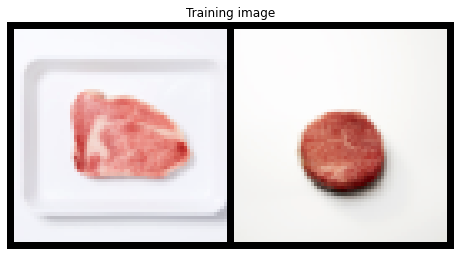

In [29]:
image_size = 64
batch_size = 2
workers = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = datasets.ImageFolder(IMG_DIR,
                                transform=transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# データローダを見てみる
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training image')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [30]:
model_G = Generator().to(device)
model_D = Discriminator().to(device)

params_G = optim.Adam(model_G.parameters(), lr=0.0002, betas=(0.5,0.999))
params_D = optim.Adam(model_D.parameters(), lr=0.0001, betas=(0.5,0.999))

#　潜在次元ベクトルz
nz = 100

# loss計算のラベル
ones = torch.ones(batch_size).to(device) # 正解 1
zeros = torch.zeros(batch_size).to(device) # 偽物 0

# 損失関数
loss_f = nn.BCEWithLogitsLoss()

# 途中結果をみるための潜在ベクトルz
check_z = torch.randn(batch_size, nz, 1, 1).to(device)


In [31]:
# 訓練関数
def train_dcgan(model_G, model_D, params_G, params_D, dataloader):
    log_loss_G = []
    log_loss_D = []
    for real_img, _ in dataloader:
        batch_len = len(real_img)

        # === Generatorを訓練する ===
        # 偽画像を生成

        z = torch.randn(batch_len, nz, 1, 1).to(device)
        fake_img = model_G(z)

        # 偽画像を一時的に保存する
        # 偽画像生成を二回行わないため
        fake_img_tensor = fake_img.detach()

        # 偽画像を本物と騙せるように計算を行う
        out = model_D(fake_img)
        loss_G = loss_f(out, ones[: batch_len])
        log_loss_G.append(loss_G.item())

        # 更新していく
        model_D.zero_grad()
        model_G.zero_grad()
        loss_G.backward()
        params_G.step()

        # == Discriminatorの訓練 ===
        # 本物の画像
        real_img = real_img.to(device)

        #本物画像を計算できるようにロスを求める
        real_out = model_D(real_img)
        loss_D_real = loss_f(real_out, ones[:batch_len])

        #さっき保存した偽画像
        fake_img = fake_img_tensor

        #偽画像を偽であると識別できるようにロスを求める
        fake_out = model_D(fake_img_tensor)
        loss_D_fake = loss_f(fake_out, zeros[:batch_len])

        #　本物，偽物のロスを合計する
        loss_D = loss_D_real + loss_D_fake
        log_loss_D.append(loss_D.item())

        # 更新してく
        model_D.zero_grad()
        model_G.zero_grad()
        loss_D.backward()
        params_D.step()
    
    return mean(log_loss_G), mean(log_loss_D)

In [32]:
for epoch in tqdm(range(1001)):
    train_dcgan(model_G, model_D, params_G, params_D, dataloader)

    # 訓練途中のモデル・生成画像の保存
    if epoch % 100 == 0:
        torch.save(
            model_G.state_dict(),
            os.path.join(OUTPUT_DIR,f"Weight_Generator/G_{epoch:03d}.pth"),
            pickle_protocol=4)
        torch.save(
            model_D.state_dict(),
            os.path.join(OUTPUT_DIR,f"Weight_Discriminator/D_{epoch:03d}.pth"),
            pickle_protocol=4)

        generated_img = model_G(check_z)
        save_image(generated_img,
                   os.path.join(OUTPUT_DIR,f"Generated_Image/{epoch:03d}.jpg"))

100%|██████████| 1000/1000 [40:01<00:00,  2.40s/it]
